In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import torch
import time
from tqdm import tqdm


import warnings
from scipy.stats import ConstantInputWarning
from sklearn.exceptions import ConvergenceWarning

# Ignore ConstantInputWarning
#warnings.filterwarnings("ignore", category=ConstantInputWarning)
#warnings.filterwarnings("ignore", category=ConvergenceWarning)
#warnings.simplefilter(action='ignore', category=FutureWarning)

In [36]:
Path='/home/mgander/Atlantic/data'

# Viability data
dfv=pd.read_pickle(f'{Path}/Viability/M_all_all.pkl')

In [37]:
Dfs = pd.read_pickle('kinobead_annotated.pkl')

In [38]:
# Only keep drugs for which I have kinobead data
drugs_kept = sorted(set(Dfs['Pubchem_CID']))
dfv = dfv[dfv['PubChem_CID'].isin(drugs_kept)].copy()
Dfs = Dfs[Dfs['Pubchem_CID'].isin(drugs_kept)].copy()

In [40]:
# Get the curves
A = Dfs[['Pubchem_CID', 'Gene', 'Curve Front', 'Curve Back', 'Curve Slope', 'pEC50']].copy()
D_curves = {}
for i in range(len(A)):
    key = A.iloc[i]['Pubchem_CID']+'_'+A.iloc[i]['Gene']
    D_curves[key]=A.iloc[i].values[-4:]

In [43]:
# Set it to 0 for all kinases that are not found
# For the rest set it to 10**(1-effect)

In [44]:
def fct(x, a, b, c, d):
    return a + (b-a) / (1+10**(-c*(x-d)))

In [45]:
kinases = sorted(set(Dfs['Gene']))

In [46]:
def get_kinase_vector(drug, conc):
    vs=[]
    keys=sorted(D_curves.keys())
    for k in kinases:
        key = drug+'_'+k
        if key in keys:
            a = D_curves[key]
            curve_value = fct(np.log10(conc*10**6), *a) / a[0]
            vs.append(1-curve_value)
        else:
            vs.append(0)
    return(vs)

In [48]:
dfvs = dfv.drop_duplicates(['PubChem_CID', 'Dose'])
dfvs.index=range(len(dfvs))

In [52]:
l=len(dfvs)
V=np.zeros((l, len(kinases)))

drugs=list(dfvs['PubChem_CID'])
concs=list(dfvs['Dose'])

for i in tqdm(range(l)):
    V[i,:]=get_kinase_vector(drugs[i], concs[i])
V = pd.DataFrame(V, columns=kinases)
V['PubChem_CID'] = dfvs['PubChem_CID']
V['Dr_repr_name'] = dfvs['Dr_repr_name']
V['Dose'] = dfvs['Dose']

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1383/1383 [01:21<00:00, 16.90it/s]


In [53]:
V.to_pickle('Kinobead_V.pkl')

In [46]:
import pickle
with open(f'V_l.pkl', 'wb') as handle:
    pickle.dump((V, dfvs, dfv), handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open(f'{Path}/DN.pkl', 'rb') as f:
#    DN = pickle.load(f)

In [34]:
dfvs['Source'].value_counts()

Source
DTP         486
CTD2        192
GDSC2       179
GDSC1       107
MR_NCI60     30
CTPR          8
Name: count, dtype: int64

In [35]:
dfv['Source'].value_counts()

Source
CTD2        286507
GDSC2       219397
GDSC1       133248
DTP          59643
MR_NCI60      9190
CTPR          1006
Name: count, dtype: int64

<Axes: >

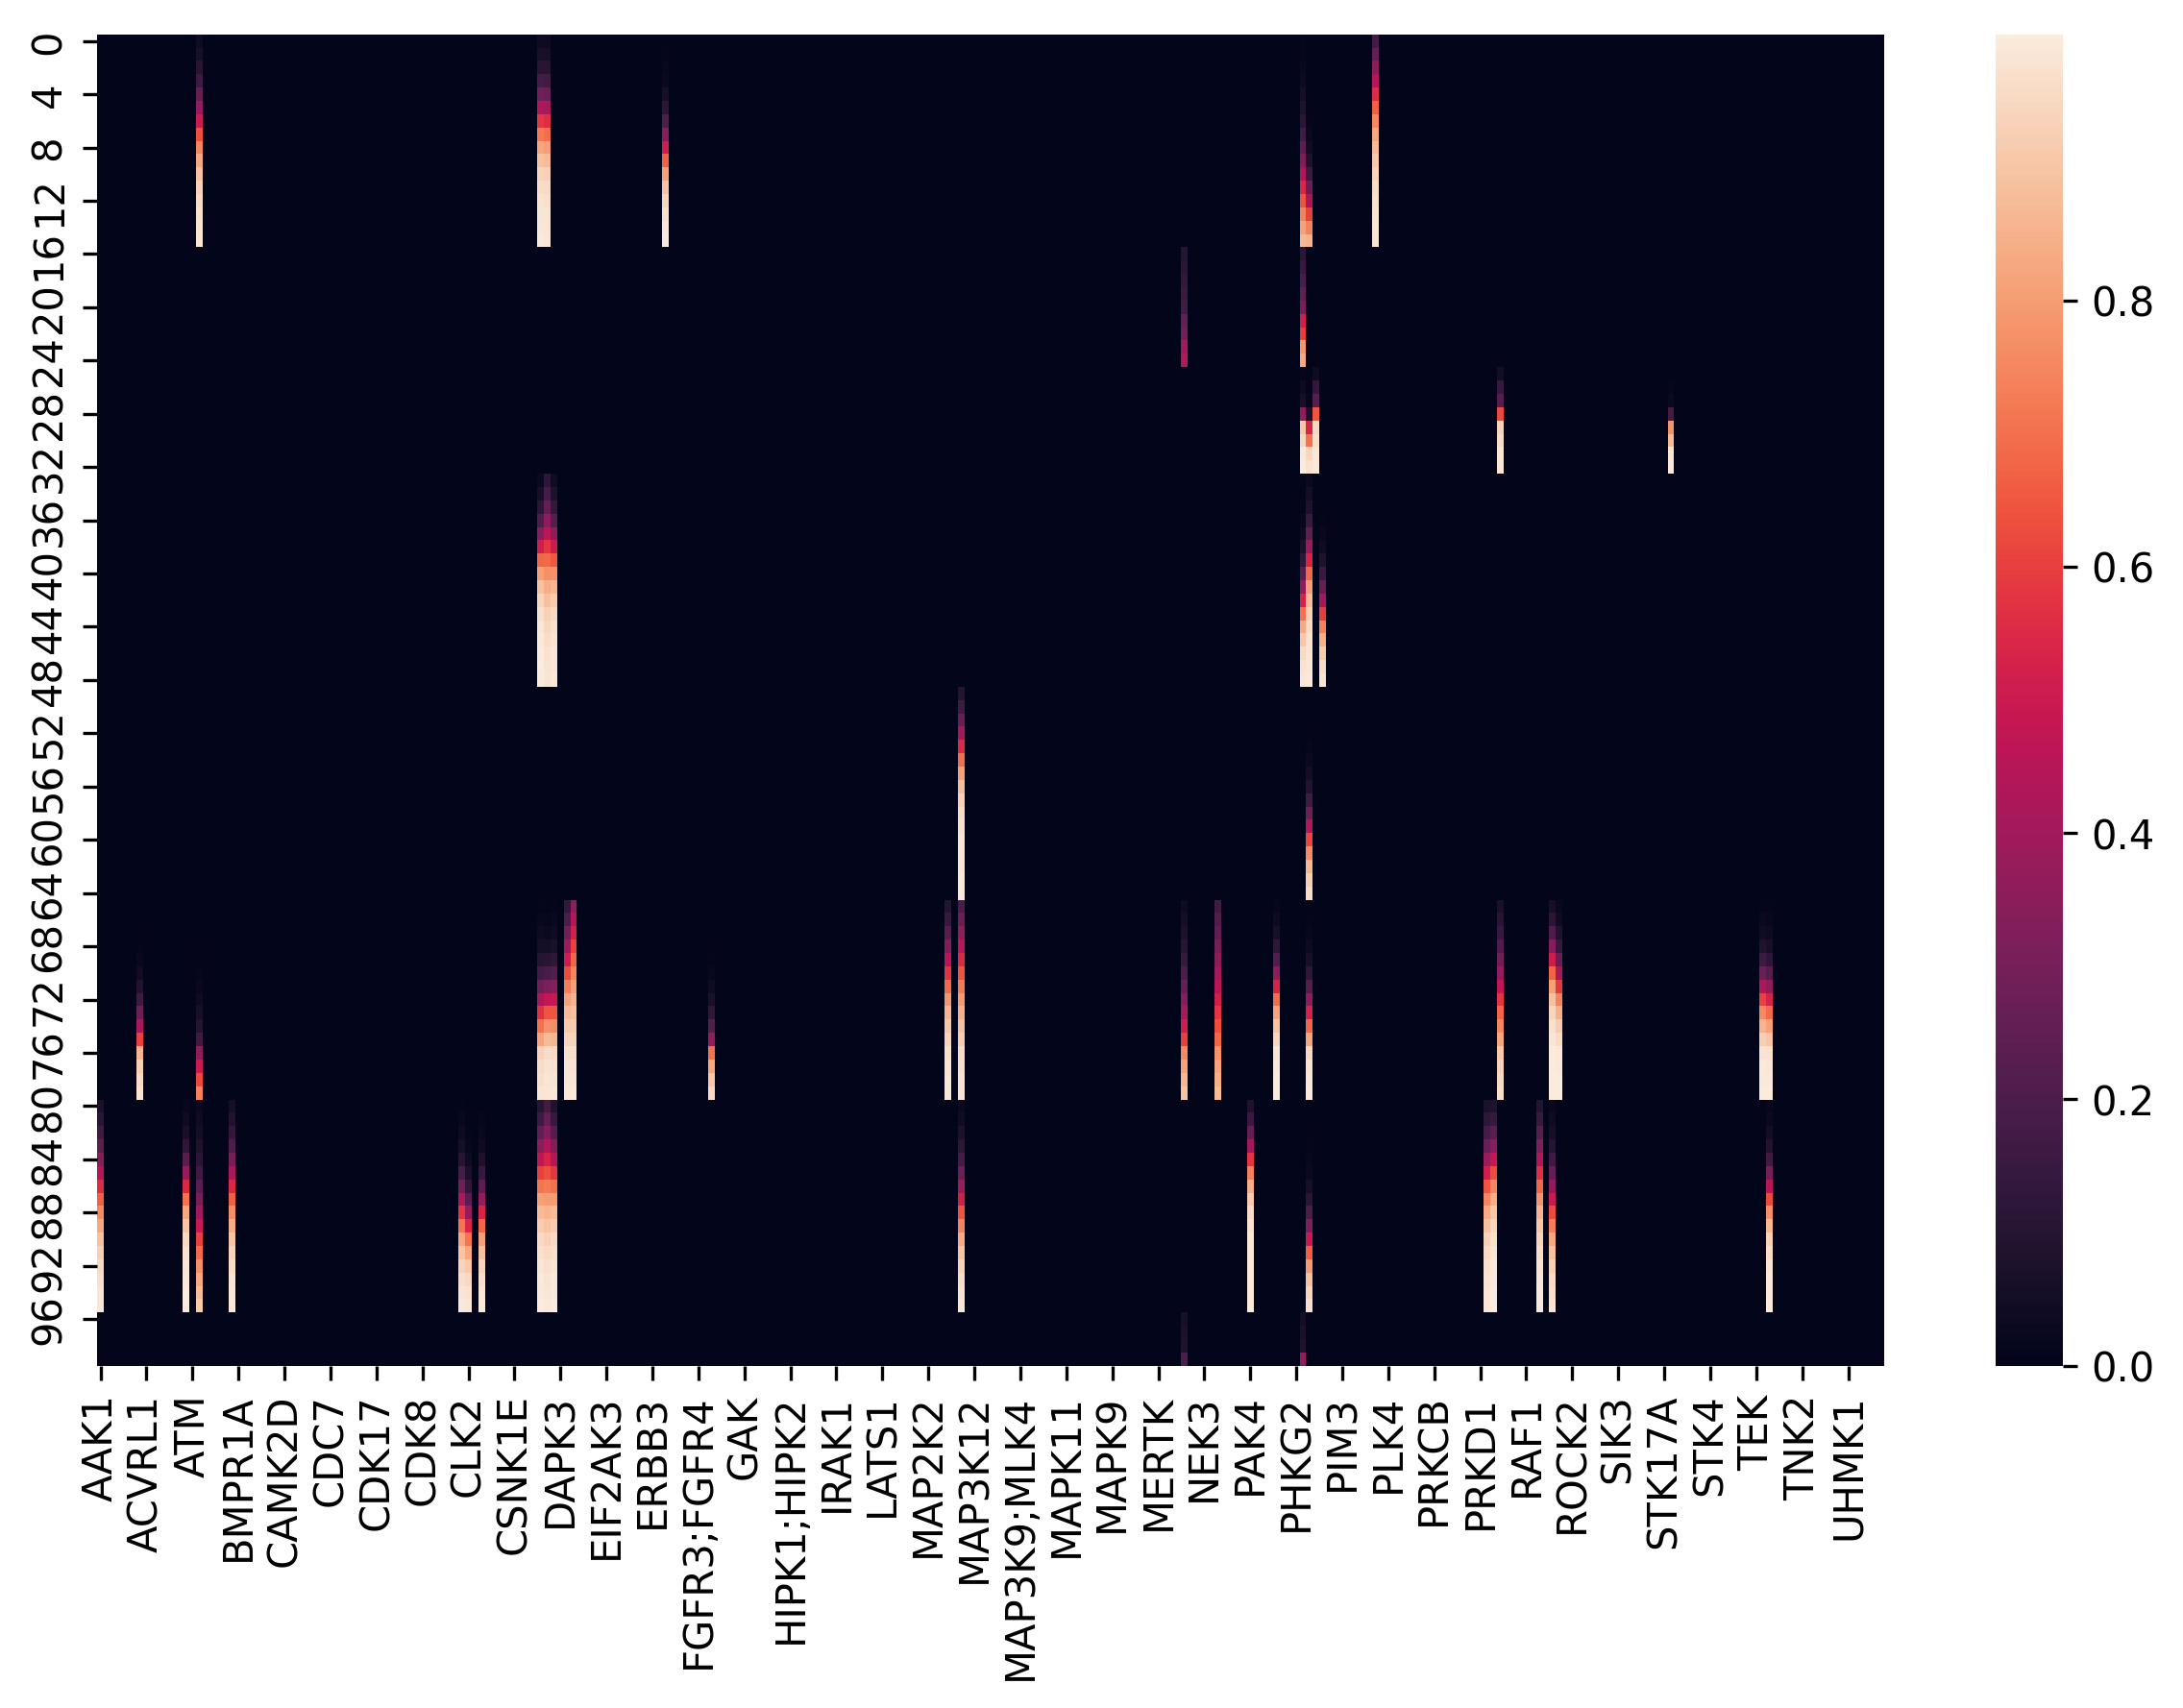

In [44]:
plt.figure(figsize=(10, 6), dpi=300)
sns.heatmap(V.iloc[:100])